In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append('./sailfish/')
if not (os.path.isdir('data') or os.path.islink('data')):
    os.mkdir('data')


In [2]:
%%writefile sq.py
"""2D flow around a square cylinder in a channel.

Lift and drag coefficients of the cylinder are measured using the
momentum exchange method.

Fully developed parabolic profile is prescribed at the inflow and
a constant pressure condition is prescribed at the outflow.

The results can be compared with:
    [1] M. Breuer, J. Bernsdorf, T. Zeiser, F. Durst
    Accurate computations of the laminar flow past a square cylinder
    based on two different methods: lattice-Boltzmann and finite-volume
    Int. J. of Heat and Fluid Flow 21 (2000) 186-196.
"""

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity, NTEquilibriumDensity, DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_base import ForceObject
from sailfish.lb_single import LBFluidSim
from sailfish.sym import S

# Geometry set to match [1].
H = 180
L = int(6.25 * H)
D = int(0.02 * L)

# St = f D / u_max

class BoxSubdomain(Subdomain2D):
    bc = NTHalfBBWall
    max_v = 0.05

    def boundary_conditions(self, hx, hy):
        walls = (hy == 0) | (hy == self.gy - 1)
        self.set_node(walls, self.bc)

        hhy = S.gy - self.bc.location
        self.set_node((hx == 0) & np.logical_not(walls),
                      NTEquilibriumVelocity(
                          DynamicValue(4.0 * self.max_v / H**2 * hhy * (H - hhy), 0.0)))
        self.set_node((hx == self.gx - 1) & np.logical_not(walls),
                      NTEquilibriumDensity(1))
        l = L / 4

        # Full bounce-back. For N box nodes, effective size is N+1.
        if self.bc.location == 0.5:
            eff_D = D - 1
        # Half-way bounce-back. For N box nodes, effective size is N-2.
        else:
            eff_D = D + 2

        box = ((hx > l - eff_D / 2.0) & (hx <= l + eff_D / 2.0) &
               (hy > (H - eff_D) / 2.0) & (hy <= (H + eff_D) / 2.0))
        self.set_node(box, self.bc)

    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        sim.vy[:] = 0.0

        hhy = hy - self.bc.location
        sim.vx[:] = 4.0 * self.max_v / H**2 * hhy * (H - hhy)


class BoxSimulation(LBFluidSim):
    subdomain = BoxSubdomain

    @classmethod
    def update_defaults(cls, defaults):
        defaults.update({
            'lat_nx': L,
            'lat_ny': (H + 2 if BoxSubdomain.bc.location == 0.5 else H),
            'precision': 'single',
            'max_iters': 1000000,
            'visc': 0.05})

    def __init__(self, *args, **kwargs):
        super(BoxSimulation, self).__init__(*args, **kwargs)

        margin = 5
        self.add_force_oject(ForceObject(
            (L / 4 - D / 2 - margin, (H - D) / 2 - margin),
            (L / 4 + D / 2 + margin, (H + D) / 2 + margin)))

        print '%d x %d | box: %d' % (L, H, D)
        print 'Re = %2.f' % (BoxSubdomain.max_v * D / self.config.visc)

    def record_value(self, iteration, force, C_D, C_L):
        print iteration, force[0], force[1], C_D, C_L

    prev_f = None
    every = 500
    def after_step(self, runner):
        if self.iteration % self.every == 0:
            runner.update_force_objects()
            for fo in self.force_objects:
                runner.backend.from_buf(fo.gpu_force_buf)
                f = fo.force()

                # Compute drag and lift coefficients.
                C_D = (2.0 * f[0] / (D * BoxSubdomain.max_v**2))
                C_L = (2.0 * f[1] / (D * BoxSubdomain.max_v**2))
                self.record_value(runner._sim.iteration, f, C_D, C_L)

                if self.prev_f is None:
                    self.prev_f = np.array(f)
                else:
                    f = np.array(f)

                    # Terminate simulation when steady state has
                    # been reached.
                    diff = np.abs(f - self.prev_f) / np.abs(f)

                    if np.all(diff < 1e-6):
                        runner._quit_event.set()
                    self.prev_f = f



ctrl = LBSimulationController(BoxSimulation)
ctrl.run()


Writing sq.py


In [58]:
%%writefile sq.py
"""2D flow around a channel.


"""

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity, NTEquilibriumDensity, DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_base import ForceObject
from sailfish.lb_single import LBFluidSim
from sailfish.sym import S

# Geometry set to match [1].
H = 4*180
L = int(6.25/4 * H)
D = int(0.02 * L)

# St = f D / u_max

class BoxSubdomain(Subdomain2D):
    bc = NTHalfBBWall
    max_v = 0.05

    def boundary_conditions(self, hx, hy):
        walls = (hy == 0) | (hy == self.gy - 1)
        self.set_node(walls, self.bc)

        hhy = S.gy - self.bc.location
        self.set_node((hx == 0) & np.logical_not(walls),
                      NTEquilibriumVelocity(
                          DynamicValue(4.0 * self.max_v / H**2 * hhy * (H - hhy), 0.0)))
        self.set_node((hx == self.gx - 1) & np.logical_not(walls),
                      NTEquilibriumDensity(1))
        l = L / 4

        # Full bounce-back. For N box nodes, effective size is N+1.
        if self.bc.location == 0.5:
            eff_D = D - 1
        # Half-way bounce-back. For N box nodes, effective size is N-2.
        else:
            eff_D = D + 2

        box = ((hx > l - eff_D / 2.0) & (hx <= l + eff_D / 2.0) &
               (hy > (H - eff_D) / 2.0) & (hy <= (H + eff_D) / 2.0))
        self.set_node(box, self.bc)

    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        sim.vy[:] = 0.0

        hhy = hy - self.bc.location
        sim.vx[:] = 4.0 * self.max_v / H**2 * hhy * (H - hhy)


class BoxSimulation(LBFluidSim):
    subdomain = BoxSubdomain

    @classmethod
    def update_defaults(cls, defaults):
        defaults.update({
            'lat_nx': L,
            'lat_ny': (H + 2 if BoxSubdomain.bc.location == 0.5 else H),
            'precision': 'single',
            'max_iters': 1000000,
            'model':'mrt',
            'visc': 0.005})

    def __init__(self, *args, **kwargs):
        super(BoxSimulation, self).__init__(*args, **kwargs)

        margin = 5
        self.add_force_oject(ForceObject(
            (L / 4 - D / 2 - margin, (H - D) / 2 - margin),
            (L / 4 + D / 2 + margin, (H + D) / 2 + margin)))

        print '%d x %d | box: %d' % (L, H, D)
        print 'Re = %2.f' % (BoxSubdomain.max_v * D / self.config.visc)

    def record_value(self, iteration, force, C_D, C_L):
        print iteration, force[0], force[1], C_D, C_L

    prev_f = None
    every = 500
    def after_step(self, runner):
        if self.iteration % self.every == 0:
            runner.update_force_objects()
            for fo in self.force_objects:
                runner.backend.from_buf(fo.gpu_force_buf)
                f = fo.force()

                # Compute drag and lift coefficients.
                C_D = (2.0 * f[0] / (D * BoxSubdomain.max_v**2))
                C_L = (2.0 * f[1] / (D * BoxSubdomain.max_v**2))
                self.record_value(runner._sim.iteration, f, C_D, C_L)

                if self.prev_f is None:
                    self.prev_f = np.array(f)
                else:
                    f = np.array(f)

                    # Terminate simulation when steady state has
                    # been reached.
                    diff = np.abs(f - self.prev_f) / np.abs(f)

                    if np.all(diff < 1e-6):
                        runner._quit_event.set()
                    self.prev_f = f



ctrl = LBSimulationController(BoxSimulation)
ctrl.run()


Overwriting sq.py


In [31]:
%%sh
rm data/sq*npz
export PYTHONPATH=$PWD/sailfish/
python sq.py --max_iters=100000 --every=1000 --from=0000 \
 --output=data/sq --output_format=npy  

1125 x 180 | box: 22
Re = 73
500 0.117350228131 -0.000275619328022 4.26728102294 -0.010022521019
1000 0.108040120453 -0.00163065269589 3.92873165282 -0.0592964616689
1500 0.0644590854645 -0.00178539007902 2.34396674416 -0.0649232756008
2000 0.0362134277821 4.60967421532e-05 1.31685191935 0.00167624516921
2500 0.0384033210576 0.000568170100451 1.39648440209 0.0206607309255
3000 0.104081004858 0.00232266634703 3.78476381302 0.0844605944373
3500 0.0630320347846 -4.16226685047e-05 2.29207399217 -0.00151355158199
4000 -0.0500670261681 0.000758606940508 -1.82061913339 0.0275857069276
4500 0.0143404863775 -0.000294167548418 0.521472231908 -0.0106970017607
5000 0.0567304603755 -0.000208329409361 2.06292583184 -0.00757561488585
5500 0.00545748695731 0.000354144722223 0.198454071175 0.012877989899
6000 0.0293093957007 -0.000710528343916 1.0657962073 -0.0258373943242
6500 0.0578350760043 -0.000116210430861 2.10309367288 -0.00422583384947
7000 0.0366496145725 5.47543168068e-05 1.33271325718 0.0019

[  1917  INFO Master/stratus] Machine master starting with PID 28244 at 2015-02-18 13:16:35 UTC
[  1950  INFO Master/stratus] Sailfish version: 9dd8b711d44c9e11614f7b760f32bdbbfa340064
[  1951  INFO Master/stratus] Handling subdomains: [0]
[  1951  INFO Master/stratus] Subdomain -> GPU map: {0: 0}
[  1951  INFO Master/stratus] Selected backend: cuda
[  2022  INFO Subdomain/0] Initializing subdomain.
[  2023  INFO Subdomain/0] Required memory: 
[  2023  INFO Subdomain/0] . distributions: 14 MiB
[  2023  INFO Subdomain/0] . fields: 2 MiB
[  4750  INFO Subdomain/0] Processing force objects.
[  4815  INFO Subdomain/0] Starting simulation.
[  8191  INFO Subdomain/0] iteration:2000  speed:103.72 MLUPS
[ 10177  INFO Subdomain/0] iteration:3000  speed:101.54 MLUPS
[ 12162  INFO Subdomain/0] iteration:4000  speed:101.77 MLUPS
[ 14124  INFO Subdomain/0] iteration:5000  speed:102.96 MLUPS
[ 16077  INFO Subdomain/0] iteration:6000  speed:103.41 MLUPS
[ 18006  INFO Subdomain/0] iteration:7000  spee

In [59]:
%%sh
rm data/sq*npz
export PYTHONPATH=$PWD/sailfish/
python sq.py --max_iters=100000 --every=100 --from=90000 \
 --output=data/sq --output_format=npy  

1125 x 720 | box: 22
Re = 220
500 0.110178526491 -1.31465494633e-05 4.0064918724 -0.000478056344119
1000 -0.00363273918629 1.65179371834e-05 -0.132099606774 0.000600652261214
1500 0.0392077937722 -9.31620597839e-05 1.42573795535 -0.00338771126487
2000 0.0375530458987 4.05684113503e-06 1.36556530541 0.000147521495819
2500 0.0401407293975 0.00039653852582 1.45966288718 0.0144195827571
3000 0.0441819578409 -6.6265463829e-05 1.60661664876 -0.00240965323015
3500 0.0314486287534 -4.11383807659e-05 1.14358650012 -0.00149594111876
4000 0.0405796915293 2.19792127609e-06 1.47562514652 7.99244100397e-05
4500 0.0314235016704 7.30231404305e-05 1.14267278801 0.00265538692474
5000 0.0318272523582 -0.000379707664251 1.15735463121 -0.0138075514273
5500 0.0388193652034 0.000629395246506 1.41161328012 0.0228870998729
6000 0.0312829501927 7.21476972103e-05 1.13756182519 0.00262355262583
6500 0.034605588764 0.000226218253374 1.25838504596 0.00822611830451
7000 0.0165075473487 -0.000724066048861 0.600274449

rm: cannot remove ‘data/sq*npz’: No such file or directory
[  1952  INFO Master/stratus] Machine master starting with PID 18155 at 2015-02-19 12:38:35 UTC
[  1983  INFO Master/stratus] Sailfish version: 9dd8b711d44c9e11614f7b760f32bdbbfa340064
[  1983  INFO Master/stratus] Handling subdomains: [0]
[  1983  INFO Master/stratus] Subdomain -> GPU map: {0: 0}
[  1983  INFO Master/stratus] Selected backend: cuda
[  2057  INFO Subdomain/0] Initializing subdomain.
[  2058  INFO Subdomain/0] Required memory: 
[  2058  INFO Subdomain/0] . distributions: 57 MiB
[  2058  INFO Subdomain/0] . fields: 9 MiB
[  5004  INFO Subdomain/0] Processing force objects.
[  5071  INFO Subdomain/0] Starting simulation.
[  6342  INFO Subdomain/0] iteration:2000  speed:1264.15 MLUPS
[  6983  INFO Subdomain/0] iteration:3000  speed:1234.89 MLUPS
[  7597  INFO Subdomain/0] iteration:4000  speed:1318.50 MLUPS
[  8190  INFO Subdomain/0] iteration:5000  speed:1363.69 MLUPS
[  8802  INFO Subdomain/0] iteration:6000  spe

In [5]:
%%time 
import glob
frames = []
s = (slice(None),slice(None))
#s = (slice(80,170,1),slice(20,220,1))
#s = (slice(None),slice(None,200,1))

for fn in sorted(glob.glob("data/sq.*.npz")):
    data =np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])
print len(frames)

100
CPU times: user 6.5 s, sys: 685 ms, total: 7.19 s
Wall time: 7.23 s


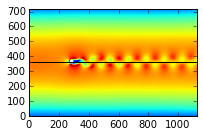

0.0694907


In [6]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'rot v': 2,'rho':3},value=0)\
         ,stream=widgets.FloatSlider(value=0.0,min=0.0,max=4.0,step=0.1,description='streamlines density:',
)
         )
def g(ith,figsize,sel,stream):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')#,vmin=-0.1,vmax=0.1)
    if stream>0:
        plt.streamplot(X,Y,vx,vy,color='white',density=stream)
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show() 
    print np.nanmax(vx)

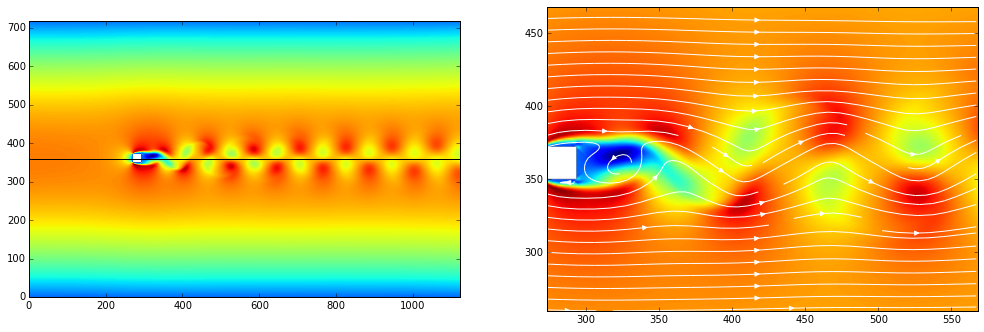

0.0700424


In [24]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'rot v': 2,'rho':3},value=0)\
         ,stream=widgets.FloatSlider(value=0.0,min=0.0,max=4.0,step=0.1,description='streamlines density:',
),
          wx = widgets.FloatRangeSlider(value=(0,nx-1),min=0,max=nx-1,step=1),
        wy = widgets.FloatRangeSlider(value=(0,ny-1),min=0,max=ny,  step=1)
         )
def g(ith,figsize,sel,stream,wx,wy):
    
    plt.figure(figsize=(figsize,2*float(ny)/nx*figsize))
    s = (slice(wy[0],wy[1],1),slice(wx[0],wx[1],1))
    vx,vy=frames[ith][:2]
    plt.subplot(1,2,1)
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    
    plt.subplot(1,2,2)
    plt.xlim(wx[0],wx[1])
    plt.ylim(wy[0],wy[1]) 
    plt.imshow(frames[ith][sel][s],origin='top',extent=(wx[0],wx[1],wy[0],wy[1]))
    if stream>0:
        plt.streamplot(X[s],Y[s],vx[s],vy[s],color='white',density=stream)
    plt.show() 
    print np.nanmax(vx)



In [22]:
wx.values

NameError: name 'wx' is not defined

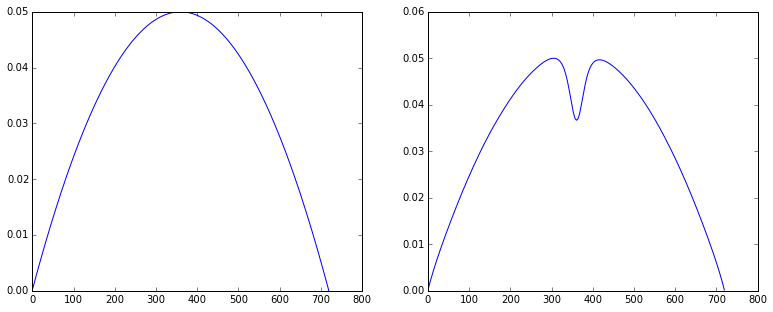

In [8]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(frames[1][0][:,0])

plt.subplot(1,2,2)
plt.plot(frames[1][0][:,250])

In [85]:
display?